In [51]:
from matplotlib import pyplot as plt
from itertools import cycle, islice
from scipy import linalg
import numpy as np

color_iter = cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                '#f781bf', '#a65628', '#984ea3',
                                                '#999999', '#e41a1c', '#dede00'])

def plot(X, y_sp, y_km, gmm):
    plt.figure(figsize=(12, 4))
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                '#f781bf', '#a65628', '#984ea3',
                                                '#999999', '#e41a1c', '#dede00']),
                                        int(max(y_km) + 1))))
    plt.subplot(131)
    plt.scatter(X[:,0], X[:,1], s=10, color=colors[y_sp])
    plt.title("Spectral Clustering")
    plt.subplot(132)
    plt.scatter(X[:,0], X[:,1], s=10, color=colors[y_km])
    plt.title("Kmeans Clustering")
    plt.subplot(133)
    Y_ = gmm.predict(X)
    for i, (mean, cov, color) in enumerate(zip(gmm.means_, gmm.covariances_,
                                           color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1],8, color=color)
    plt.title("GMM Clustering")
    # plt.show()
    plt.savefig("./figure/spectral_clustering_separatedguassian1.png")

In [15]:
from sklearn.mixture import GaussianMixture

In [44]:
def genTwoCircles(n_samples=1000):
    X,y = datasets.make_circles(n_samples, factor=0.5, noise=0.05)
    return X, y

def genTwoMoons(n_samples=1000):
    X,y = datasets.make_moons(n_samples, noise=0.05)
    return X,y

def genTwoGaussians(n_samples=1000):
    np.random.seed(0)
    C = np.array([[0.5, -0.1], [.7, 1.4]])
    X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3]),
         .5 * np.random.randn(n_samples, 2) + np.array([-8, -4])]
    return X,C

In [ ]:
from utils.similarity import calEuclidDistanceMatrix
from utils.knn import myKNN
from utils.laplacian import calLaplacianMatrix
# from utils.dataloader import genTwoMoons
# from utils.ploter import plot
from sklearn.cluster import KMeans,spectral_clustering
import numpy as np
np.random.seed(1)

data, label = genTwoGaussians(n_samples=500)

Similarity = calEuclidDistanceMatrix(data)

Adjacent = myKNN(Similarity, k=8)

Laplacian = calLaplacianMatrix(Adjacent)

x, V = np.linalg.eig(Laplacian)

x = zip(x, range(len(x)))
x = sorted(x, key=lambda x:x[0])

H = np.vstack([V[:,i] for (v, i) in x[:500]]).T

# sp_kmeans = KMeans(n_clusters=3).fit(H)
sp_kmeans = spectral_clustering(n_clusters=3,assign_labels='kmeans',affinity='nearest_neighbors').fit(data)

pure_kmeans = KMeans(n_clusters=3).fit(data)

gmm = GaussianMixture(n_components=3).fit(data)

plot(data, sp_kmeans.labels_, pure_kmeans.labels_,gmm)

In [109]:
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import cross_val_score

def gen_dataset(n_samples, snr, rank,n_features=10):
    U, S, _ = linalg.svd(np.random.randn(n_features, n_features))
    sigma = S[-1]/(snr-1)
    X = np.dot(np.random.randn(n_samples, rank), U[:, :rank].T)
    X = X+ np.random.randn(n_samples, n_features)*sigma
    
    return X

sample_size=[25,50,100,250,500,1000]
SNR=[1.2,1.5,2,2.5,3,3.5,4,8,16]
#3,5,7]

def compute_scores(X,n_features=10):
    fa = FactorAnalysis()
    n_components = np.arange(1, 10)
    aic , bic = [], []
    for n in n_components:
        fa.n_components = n
        fa.fit(X)
#         print(fa.score(X))
        aic.append(  fa.score(X) * X.shape[0] -  n*n_features)
        bic.append( fa.score(X) * X.shape[0] -0.5*
                n*n_features * np.log(X.shape[0]))

    return aic,bic


In [131]:
y_dim=[7]

In [132]:
log = []
for i in sample_size:
    for j in SNR:
        for l in y_dim:
            aic_success = 0
            bic_success = 0
            for k in range(100):
                X=gen_dataset(n_samples=i,snr=j,rank=l)
                aic,bic=compute_scores(X)
                if l == np.argmax(np.array(aic))+1:
                    aic_success+=1
                if l == np.argmax(np.array(bic))+1:
                    bic_success+=1
            log.append((i,j,l,aic_success/100,bic_success/100))

C:\Users\StHow\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


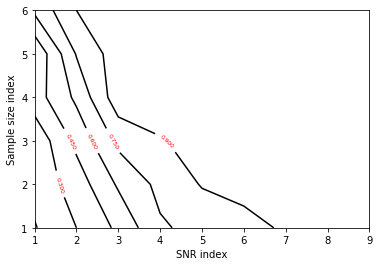

In [133]:
z_aic,z_bic=[],[]
for i in range(len(log)):
#     if log[i][2]==3:
    
    z_aic.append(log[i][3])
    z_bic.append(log[i][4])

x=np.arange(1,7)
y=np.arange(1,10)
x,y== np.meshgrid(x,y)
z_aic=np.array(z_aic).reshape(6,9)
contour=plt.contour(y,x,z_aic,colors='k')
plt.clabel(contour,fontsize=6,colors=('r'))
plt.ylabel('Sample size index')
plt.xlabel('SNR index')
plt.savefig('figure/aic_7.pdf')

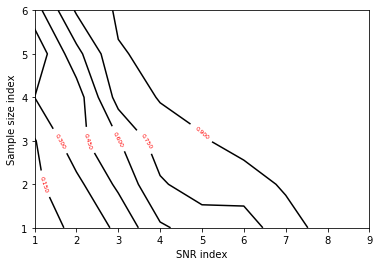

In [134]:
z_bic=np.array(z_bic).reshape(6,9)
contour=plt.contour(y,x,z_bic,colors='k')
plt.clabel(contour,fontsize=6,colors=('r'))
plt.ylabel('Sample size index')
plt.xlabel('SNR index')
plt.savefig('figure/bic_7.pdf')

In [130]:
log

[(25, 1.2, 5, 0.26, 0.23),
 (25, 1.5, 5, 0.51, 0.44),
 (25, 2, 5, 0.79, 0.71),
 (25, 2.5, 5, 0.92, 0.82),
 (25, 3, 5, 0.95, 0.91),
 (25, 3.5, 5, 0.97, 0.98),
 (25, 4, 5, 1.0, 0.99),
 (25, 8, 5, 1.0, 1.0),
 (25, 16, 5, 1.0, 1.0),
 (50, 1.2, 5, 0.31, 0.24),
 (50, 1.5, 5, 0.64, 0.56),
 (50, 2, 5, 0.97, 0.86),
 (50, 2.5, 5, 1.0, 0.95),
 (50, 3, 5, 1.0, 0.99),
 (50, 3.5, 5, 0.99, 1.0),
 (50, 4, 5, 0.99, 1.0),
 (50, 8, 5, 1.0, 1.0),
 (50, 16, 5, 1.0, 1.0),
 (100, 1.2, 5, 0.38, 0.28),
 (100, 1.5, 5, 0.73, 0.58),
 (100, 2, 5, 0.99, 0.85),
 (100, 2.5, 5, 1.0, 0.97),
 (100, 3, 5, 1.0, 0.99),
 (100, 3.5, 5, 0.99, 1.0),
 (100, 4, 5, 1.0, 1.0),
 (100, 8, 5, 0.99, 1.0),
 (100, 16, 5, 1.0, 1.0),
 (250, 1.2, 5, 0.54, 0.41),
 (250, 1.5, 5, 0.92, 0.76),
 (250, 2, 5, 1.0, 0.99),
 (250, 2.5, 5, 1.0, 1.0),
 (250, 3, 5, 1.0, 1.0),
 (250, 3.5, 5, 1.0, 1.0),
 (250, 4, 5, 1.0, 1.0),
 (250, 8, 5, 1.0, 1.0),
 (250, 16, 5, 1.0, 1.0),
 (500, 1.2, 5, 0.61, 0.48),
 (500, 1.5, 5, 0.98, 0.85),
 (500, 2, 5, 0.99, 0.99)